# Proyecto clasificador de paquetes

### 1.1 Contexto del Negocio y Antecedentes
Una importante compañía de envíos ha decidido modernizar su sistema de ruteo de correspondencia, paquetes y encomiendas. Actualmente, el proceso de clasificación se realiza de manera semi-automática y con intervención manual, lo que ocasiona demoras y errores en la entrega.

El negocio ha identificado que el reconocimiento automático de los dígitos que componen el código postal en los paquetes puede agilizar el proceso y reducir costos operativos, mejorando la satisfacción del cliente.

### 1.2 Objetivo del Proyecto
El propósito es desarrollar un sistema de reconocimiento de dígitos basado en un modelo de red neuronal convolucional que:

Identifique correctamente los dígitos del código postal en imágenes de paquetes.
Automatice el ruteo y la clasificación en función del código postal.

### 1.4 Métricas de Éxito
- Precisión (Accuracy): Porcentaje de dígitos reconocidos correctamente en cada imagen.
- Tiempo de Inferencia: Tiempo requerido para procesar cada imagen, clave para aplicaciones en tiempo real.
- Número de Parámetros: Comparación de la eficiencia del modelo, evaluando la complejidad y capacidad de generalización.

### 1.5 Desafíos y Consideraciones
- Calidad y Variabilidad de las Imágenes: Diferentes condiciones de iluminación, ángulos y ruido pueden dificultar la clasificación.

- Overfitting y Underfitting: Balancear la complejidad del modelo para que no se adapte excesivamente a las muestras de entrenamiento.

## Flujo
1. Cargar el dataset original ✅
2. Aplicar limpieza inicial 🧹
   - Eliminar imágenes completamente negras o blancas
   - Eliminar imágenes borrosas o con varianza muy baja
   - Opcional: revisar por etiquetas inconsistentes (si lo quieres hacer más fino)
3. Aplicar SMOTE (sobre datos ya limpios) 🧠
4. Aplicar limpieza ligera post-SMOTE (por si genera imágenes raras)
5. Preparar augmentación → usar durante el entrenamiento (no aumentar antes) 🔄
6. Entrenar el modelo 🚀

## 1. Carga y Exploración de los Datos

### 1.1 Dataset para Entrenamiento
En esta celda, vamos a cargar el dataset MNIST desde TensorFlow/Keras, explorar las primeras imágenes y examinar la distribución de las clases.

Código para cargar y explorar los datos:

In [1]:
! pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cargar el dataset MNIST desde TensorFlow/Keras
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Cargar el conjunto de entrenamiento y prueba
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Verificar las formas de los conjuntos de datos
print(f"Conjunto de entrenamiento imágenes: {train_images.shape}")
print(f"Conjunto de entrenamiento etiquetas: {train_labels.shape}")
print(f"Conjunto de prueba imágenes: {test_images.shape}")
print(f"Conjunto de prueba etiquetas: {test_labels.shape}")

Conjunto de entrenamiento imágenes: (60000, 28, 28)
Conjunto de entrenamiento etiquetas: (60000,)
Conjunto de prueba imágenes: (10000, 28, 28)
Conjunto de prueba etiquetas: (10000,)


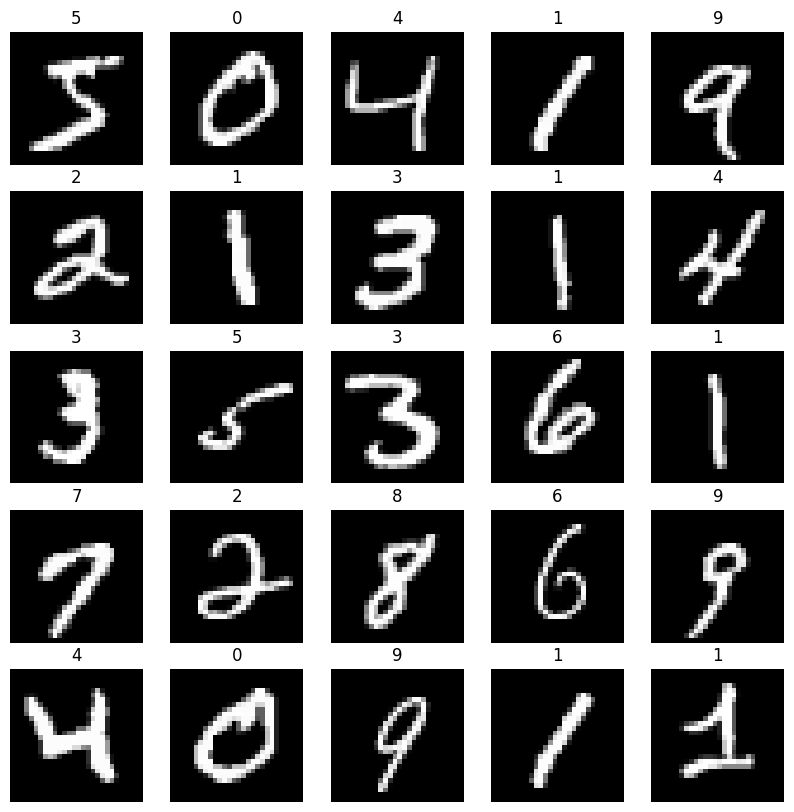

In [3]:
# Visualizamos algunas imágenes del conjunto de entrenamiento
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(str(train_labels[i]))
    plt.axis('off')
plt.show()

#### Histograma de distribución

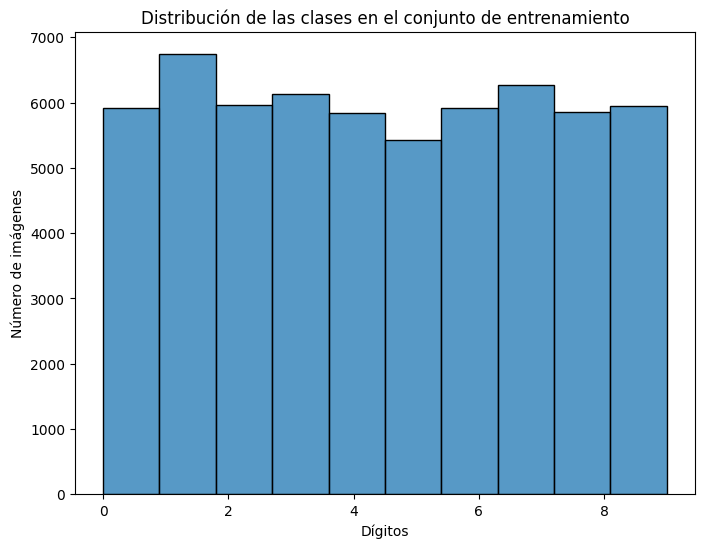

In [4]:
# Análisis de la distribución de las etiquetas (dígitos del 0 al 9)
plt.figure(figsize=(8, 6))
sns.histplot(train_labels, bins=10, kde=False)
plt.title('Distribución de las clases en el conjunto de entrenamiento')
plt.xlabel('Dígitos')
plt.ylabel('Número de imágenes')
plt.show()

**Explicación del código:**

Carga de datos: Usamos la función mnist.load_data() de Keras para cargar el dataset MNIST. Esta función nos devuelve dos tuplas: una para el conjunto de entrenamiento (train_images, train_labels) y otra para el conjunto de prueba (test_images, test_labels).

Exploración inicial: Se imprime la forma de los conjuntos de datos (número de imágenes y su tamaño). También visualizamos 25 imágenes del conjunto de entrenamiento con sus respectivas etiquetas (los dígitos que representan).

Distribución de las clases: Se muestra un histograma que nos permite ver la distribución de los dígitos en el conjunto de entrenamiento. Esto nos ayudará a saber si el dataset está equilibrado o si existe alguna clase con más o menos representaciones.

#### Limpieza de imágenes

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# --- 1. Detectar imágenes completamente negras o blancas ---
imagenes_negras = [i for i in range(len(train_images)) if np.max(train_images[i]) == 0]
imagenes_blancas = [i for i in range(len(train_images)) if np.min(train_images[i]) == 255]

# --- 2. Detectar imágenes borrosas (varianza muy baja) ---
varianzas = np.var(train_images, axis=(1, 2))
umbral_bajo = np.percentile(varianzas, 2)  # El 2% más bajo
imagenes_borrosas = np.where(varianzas < umbral_bajo)[0]

# --- 3. Unir todos los índices a eliminar ---
indices_a_eliminar = set(imagenes_negras + imagenes_blancas + list(imagenes_borrosas))

# --- 4. Eliminar imágenes del conjunto de entrenamiento ---
train_images_limpias = np.delete(train_images, list(indices_a_eliminar), axis=0)
train_labels_limpias = np.delete(train_labels, list(indices_a_eliminar), axis=0)

print(f"Después de limpieza: {train_images_limpias.shape[0]} imágenes")

Después de limpieza: 58800 imágenes


Volvemos a analizar la distribución de las etiquetas (dígitos del 0 al 9)

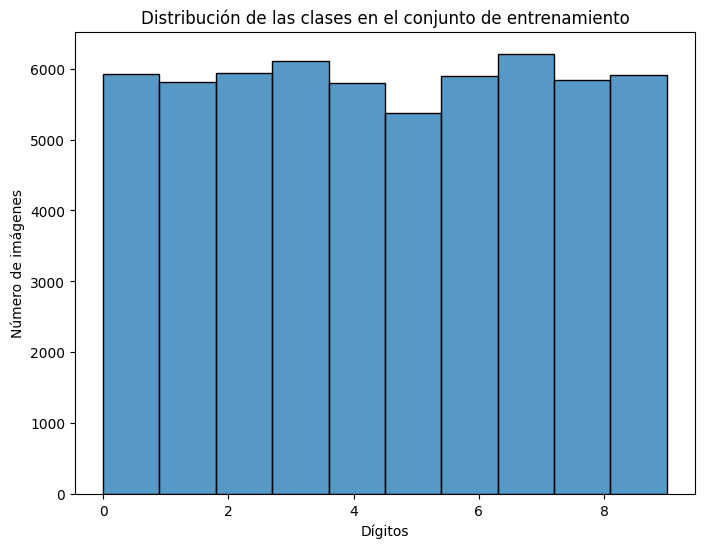

In [6]:
# Análisis de la distribución de las etiquetas (dígitos del 0 al 9)
plt.figure(figsize=(8, 6))
sns.histplot(train_labels_limpias, bins=10, kde=False)
plt.title('Distribución de las clases en el conjunto de entrenamiento')
plt.xlabel('Dígitos')
plt.ylabel('Número de imágenes')
plt.show()

### 1.2 Análisis Exploratorio y Visualización

#### Oversampling con SMOTE

SMOTE no trabaja directamente con imágenes, así que necesitamos aplanar las imágenes antes de aplicarlo.

In [7]:

from imblearn.over_sampling import SMOTE
from collections import Counter

# Aplanar las imágenes de 28x28 a vectores de 784 características
train_images_flat = train_images_limpias.reshape(train_images_limpias.shape[0], -1)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(sampling_strategy='auto', random_state=42)
train_images_resampled, train_labels_resampled = smote.fit_resample(train_images_flat, train_labels_limpias)

# Restaurar la forma original de las imágenes después de SMOTE
train_images_resampled = train_images_resampled.reshape(-1, 28, 28, 1)

# Verificar la distribución de clases después del balanceo
counter = Counter(train_labels_resampled)
print(f"Distribución después de SMOTE: {counter}")

Distribución después de SMOTE: Counter({np.uint8(5): 6203, np.uint8(0): 6203, np.uint8(4): 6203, np.uint8(1): 6203, np.uint8(9): 6203, np.uint8(2): 6203, np.uint8(3): 6203, np.uint8(6): 6203, np.uint8(7): 6203, np.uint8(8): 6203})


**Dataset original:**

- Había 58800 imágenes en total.

**Después de SMOTE:**

Todas las clases tienen 6,203 imágenes cada una.

SMOTE generó nuevas imágenes sintéticas hasta que cada clase tuviera el mismo número de ejemplos.

Como hay 10 clases (0-9), el nuevo total es:

6,203 x 10 = `62,030 imagenes`

62,030 - 58800 = `3,230 nuevas imágenes` agregadas al conjunto de entrenamiento.

✅ Verificación: Si el total de imágenes después de SMOTE es 62,030, entonces el proceso funcionó correctamente. Puedes verificarlo con:

In [8]:
print(f"Total de imágenes después de SMOTE: {train_images_resampled.shape[0]}")

Total de imágenes después de SMOTE: 62030


#### Detección de Anomalías en las Imágenes Post-SMOTE

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

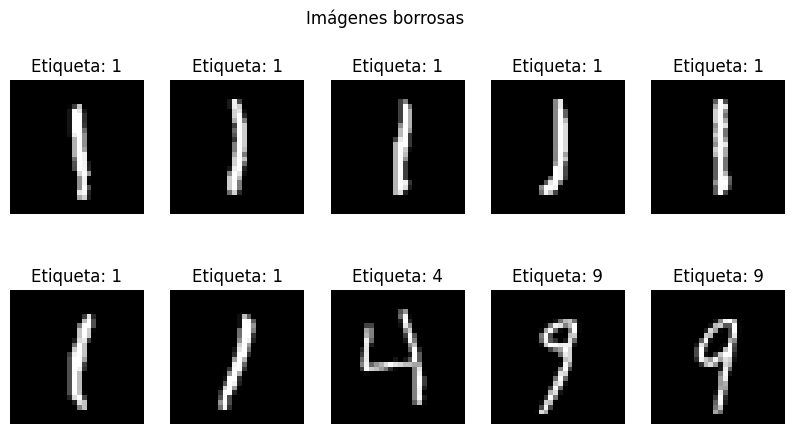

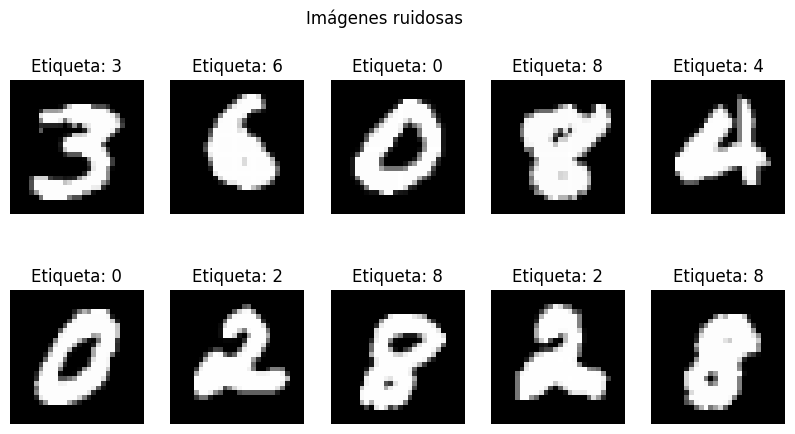

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Función para visualizar imágenes sospechosas
def mostrar_imagenes(indices, images, labels, title):
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices[:10]):  # Muestra las primeras 10 imágenes sospechosas
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx].squeeze(), cmap="gray")
        plt.title(f"Etiqueta: {labels[idx]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# 1. Buscar imágenes con valores extremos (pixeles completamente negros o blancos)
imagenes_negras = [i for i in range(len(train_images_resampled)) if np.max(train_images_resampled[i]) == 0]
imagenes_blancas = [i for i in range(len(train_images_resampled)) if np.min(train_images_resampled[i]) == 255]

# 2. Buscar imágenes borrosas o ruidosas (varianza muy baja o alta)
varianzas = np.var(train_images_resampled, axis=(1, 2, 3))
umbral_bajo = np.percentile(varianzas, 2)  # 2% más bajas (muy borrosas)
umbral_alto = np.percentile(varianzas, 98)  # 2% más altas (ruidosas)
imagenes_borrosas = np.where(varianzas < umbral_bajo)[0]
imagenes_ruidosas = np.where(varianzas > umbral_alto)[0]

# Mostrar algunas imágenes detectadas como anómalas
mostrar_imagenes(imagenes_negras, train_images_resampled, train_labels_resampled, "Imágenes completamente negras")
mostrar_imagenes(imagenes_blancas, train_images_resampled, train_labels_resampled, "Imágenes completamente blancas")
mostrar_imagenes(imagenes_borrosas, train_images_resampled, train_labels_resampled, "Imágenes borrosas")
mostrar_imagenes(imagenes_ruidosas, train_images_resampled, train_labels_resampled, "Imágenes ruidosas")

Podemos detectar imágenes con problemas como:

- Imágenes corruptas (píxeles aleatorios o completamente en negro/blanco).
- Dígitos mal centrados o rotados.
- Baja calidad (dígitos borrosos, con ruido o difícilmente legibles).
- Etiquetas incorrectas (ejemplo: un "5" etiquetado como "6").

#### **Manejo de Anomalías**
Una vez detectadas, tenemos varias estrategias:

- Imágenes completamente negras o blancas: Se pueden eliminar, ya que no aportan información útil.
- Imágenes borrosas: Se pueden eliminar o intentar mejorar con técnicas de filtrado.
- Imágenes ruidosas: Se pueden filtrar usando técnicas como mediana o suavizado Gaussiano.
- Etiquetas incorrectas: Se pueden revisar manualmente y corregir si es necesario.

In [10]:
# Crear una lista de índices a eliminar
indices_a_eliminar = set(imagenes_negras + imagenes_blancas + list(imagenes_borrosas) + list(imagenes_ruidosas))

# Filtrar el dataset eliminando las imágenes sospechosas
train_images_filtradas = np.delete(train_images_resampled, list(indices_a_eliminar), axis=0)
train_labels_filtradas = np.delete(train_labels_resampled, list(indices_a_eliminar), axis=0)

print(f"Número de imágenes después de limpieza: {train_images_filtradas.shape[0]}")

Número de imágenes después de limpieza: 59548


In [11]:
from collections import Counter

# Contar la cantidad de imágenes por clase después de la limpieza
counter_filtrado = Counter(train_labels_filtradas)
print(f"Distribución después de limpieza: {counter_filtrado}")

Distribución después de limpieza: Counter({np.uint8(7): 6102, np.uint8(4): 6093, np.uint8(3): 6075, np.uint8(9): 6070, np.uint8(6): 6041, np.uint8(5): 6028, np.uint8(2): 6015, np.uint8(8): 5986, np.uint8(0): 5640, np.uint8(1): 5498})


## 2. Preprocesamiento de los Datos

- 2.1 Normalización y Redimensionamiento

Las imágenes del dataset MNIST ya tienen un tamaño fijo de 28x28 píxeles, por lo que no es necesario redimensionarlas. Sin embargo, es importante normalizar los valores de los píxeles para que estén en el rango [0, 1], lo cual ayudará a estabilizar el proceso de entrenamiento. La normalización se logra dividiendo los valores de los píxeles (que están en el rango de 0 a 255) entre 255.


- 2.2 Redimensionar para la Red Neuronal

Las redes neuronales convolucionales (CNN) requieren que las imágenes tengan una forma específica. Dado que el conjunto MNIST tiene imágenes en escala de grises (1 canal), necesitamos asegurarnos de que las imágenes tengan la forma (28, 28, 1) en lugar de (28, 28).


- 2.3 División del Conjunto de Datos (Entrenamiento, Validación y Prueba)

Es recomendable dividir el conjunto de entrenamiento en dos partes: entrenamiento y validación. Usaremos un 15% del conjunto de entrenamiento para validación, y el 85% restante para entrenar el modelo. El conjunto de prueba será utilizado al final para evaluar el rendimiento del modelo.

Código para preprocesar los datos:

In [12]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# Normalización del dataset final limpio y balanceado
train_images_normalizadas = train_images_filtradas / 255.0
train_images_normalizadas = train_images_normalizadas.reshape(-1, 28, 28, 1)

# Normalización y reshape del set de prueba
test_images = test_images / 255.0
test_images = test_images.reshape(-1, 28, 28, 1)

# División en entrenamiento y validación usando los datos finales
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_images_normalizadas,
    train_labels_filtradas,
    test_size=0.15,
    stratify=train_labels_filtradas,
    random_state=42
)

# Convertir las etiquetas a formato one-hot
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
test_labels = to_categorical(test_labels, 10)

# Verificar formas
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de validación: {X_val.shape}, {y_val.shape}")
print(f"Conjunto de prueba: {test_images.shape}, {test_labels.shape}")

Conjunto de entrenamiento: (50615, 28, 28, 1), (50615, 10)
Conjunto de validación: (8933, 28, 28, 1), (8933, 10)
Conjunto de prueba: (10000, 28, 28, 1), (10000, 10)


✅ Validación del output:

- Conjunto de entrenamiento:
50,615 imágenes — excelente tamaño para aprendizaje.

- Conjunto de validación:
8,933 imágenes — equivale al ~15% del total, correcto.

- Conjunto de prueba:
10,000 imágenes del set original de MNIST sin modificar (como debe ser para pruebas justas).


## Model Building

### CNN Base (modelo inicial)

### Implementación con K-Fold Cross-Validation

c:\Users\Alumno_AI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Precisión del pliegue: 0.9979
Pérdida del pliegue: 0.0061
Tiempo de entrenamiento para este pliegue: 50.84 segundos


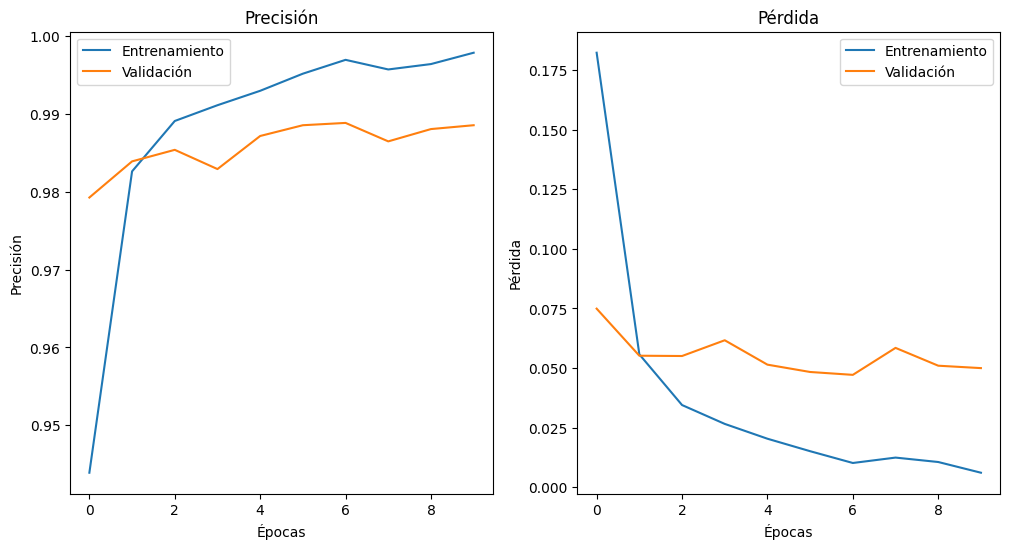

Precisión del pliegue: 0.9968
Pérdida del pliegue: 0.0102
Tiempo de entrenamiento para este pliegue: 51.88 segundos


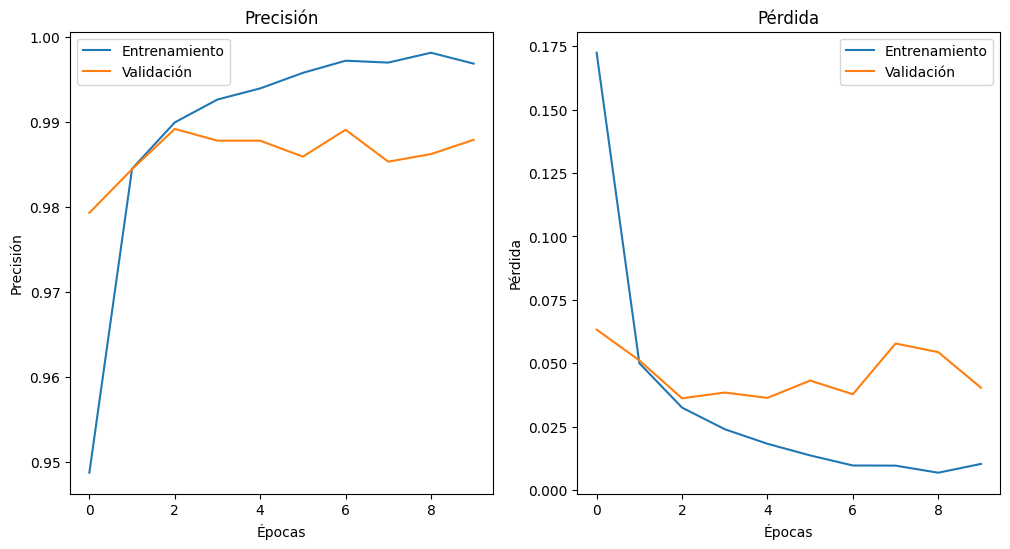

Precisión del pliegue: 0.9979
Pérdida del pliegue: 0.0070
Tiempo de entrenamiento para este pliegue: 51.96 segundos


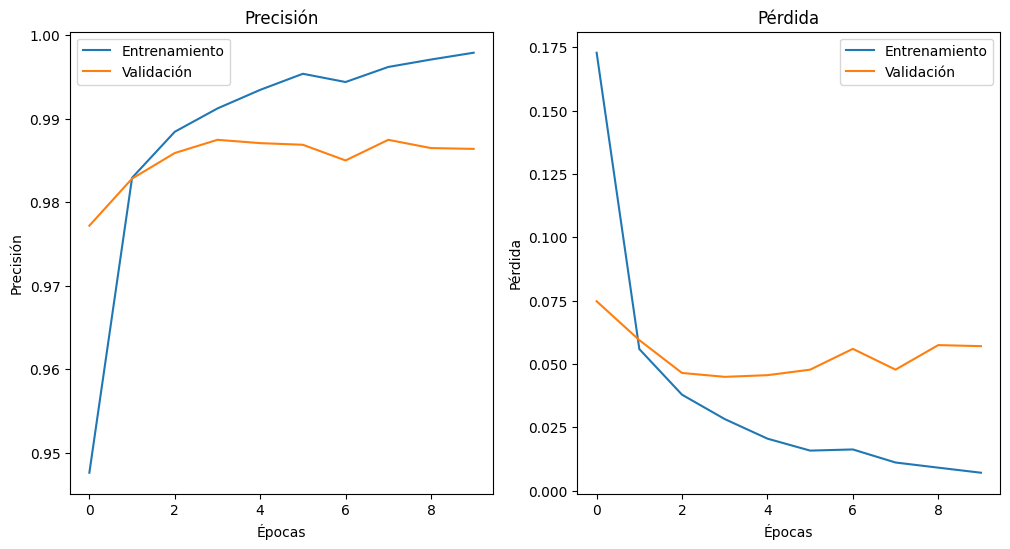

Precisión del pliegue: 0.9975
Pérdida del pliegue: 0.0082
Tiempo de entrenamiento para este pliegue: 51.35 segundos


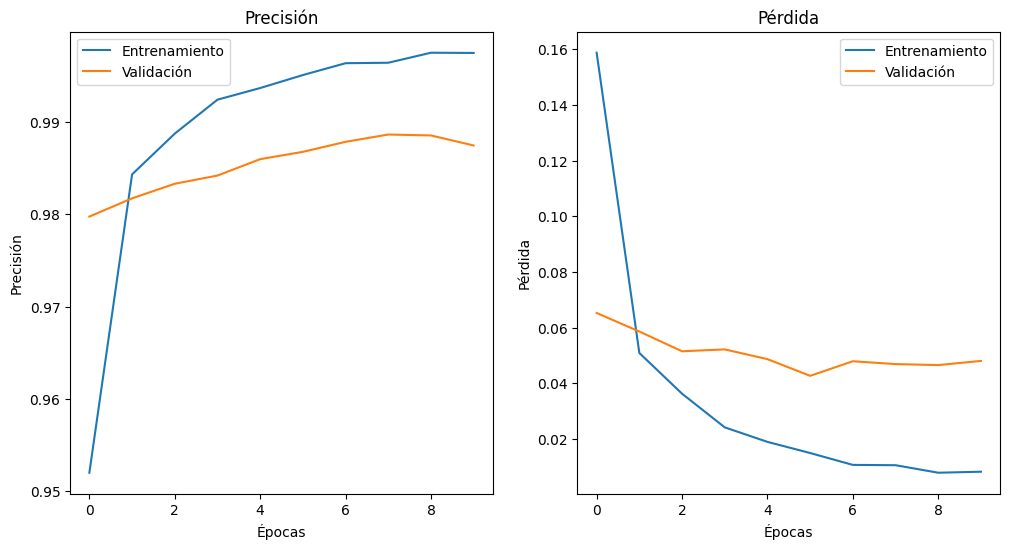

Precisión del pliegue: 0.9977
Pérdida del pliegue: 0.0071
Tiempo de entrenamiento para este pliegue: 50.61 segundos


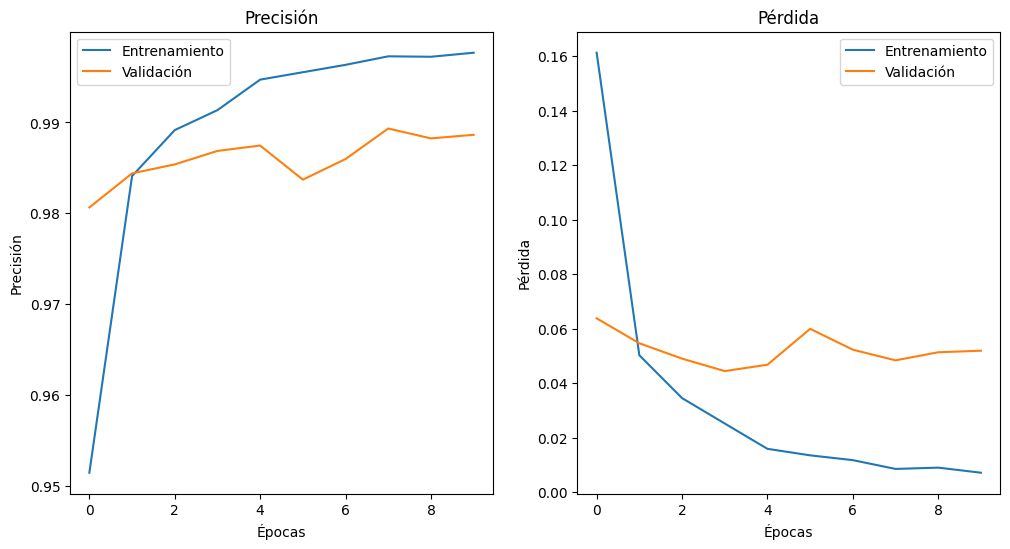


Precisión promedio: 0.9975
Pérdida promedio: 0.0077
Tiempo promedio de entrenamiento: 51.33 segundos

Mejor precisión de validación: 0.9886
Mejor configuración: {'epochs': 10, 'batch_size': 64, 'optimizer': 'adam', 'loss_function': 'categorical_crossentropy', 'conv_layers': [32, 64], 'dense_units': 128}
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9861 - loss: 0.0556

Precisión en el conjunto de prueba: 0.9884
Pérdida en el conjunto de prueba: 0.0469


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Definir el modelo base con He Normal como inicializador
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer=HeNormal()),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu', kernel_initializer=HeNormal()),
        Dense(10, activation='softmax', kernel_initializer=HeNormal())  # La capa de salida no necesita He Normal
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Función para visualizar la precisión y pérdida del entrenamiento
def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    
    plt.show()

# Validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
losses = []
times = []
best_model = None  # Variable para almacenar el mejor modelo
best_val_accuracy = 0  # Variable para almacenar la mejor precisión de validación
best_config = None  # Almacenar la configuración del mejor modelo

# Guardar configuraciones
configurations = []

for train_idx, val_idx in kfold.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Crear el modelo
    model = create_model()

    # Medir el tiempo de entrenamiento
    start_time = time.time()

    # Entrenamiento del modelo
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold), verbose=0)

    end_time = time.time()
    time_taken = end_time - start_time
    times.append(time_taken)

    # Guardar precisión y pérdida
    accuracies.append(history.history['accuracy'][-1])
    losses.append(history.history['loss'][-1])

    print(f"Precisión del pliegue: {accuracies[-1]:.4f}")
    print(f"Pérdida del pliegue: {losses[-1]:.4f}")
    print(f"Tiempo de entrenamiento para este pliegue: {time_taken:.2f} segundos")

    # Almacenar la configuración del modelo para este pliegue
    current_config = {
        'epochs': 10,  # Número de épocas
        'batch_size': 64,  # Tamaño del lote
        'optimizer': 'adam',  # Optimización usada
        'loss_function': 'categorical_crossentropy',  # Función de pérdida usada
        'conv_layers': [32, 64],  # Número de filtros en las capas convolucionales
        'dense_units': 128,  # Unidades en la capa densa
    }
    configurations.append(current_config)

    # Si la precisión de validación es mejor que la anterior, guarda el modelo y la configuración
    if history.history['val_accuracy'][-1] > best_val_accuracy:
        best_val_accuracy = history.history['val_accuracy'][-1]
        best_model = model  # Guardar el mejor modelo
        best_config = current_config  # Guardar la configuración del mejor modelo

    # Visualizar los resultados de este pliegue
    plot_history(history)

# Resultados de K-Fold
avg_accuracy = np.mean(accuracies)
avg_loss = np.mean(losses)
avg_time = np.mean(times)

print(f"\nPrecisión promedio: {avg_accuracy:.4f}")
print(f"Pérdida promedio: {avg_loss:.4f}")
print(f"Tiempo promedio de entrenamiento: {avg_time:.2f} segundos")

# Mostrar la mejor configuración
print(f"\nMejor precisión de validación: {best_val_accuracy:.4f}")
print(f"Mejor configuración: {best_config}")

# Evaluar el mejor modelo en el conjunto de prueba
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"\nPrecisión en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")


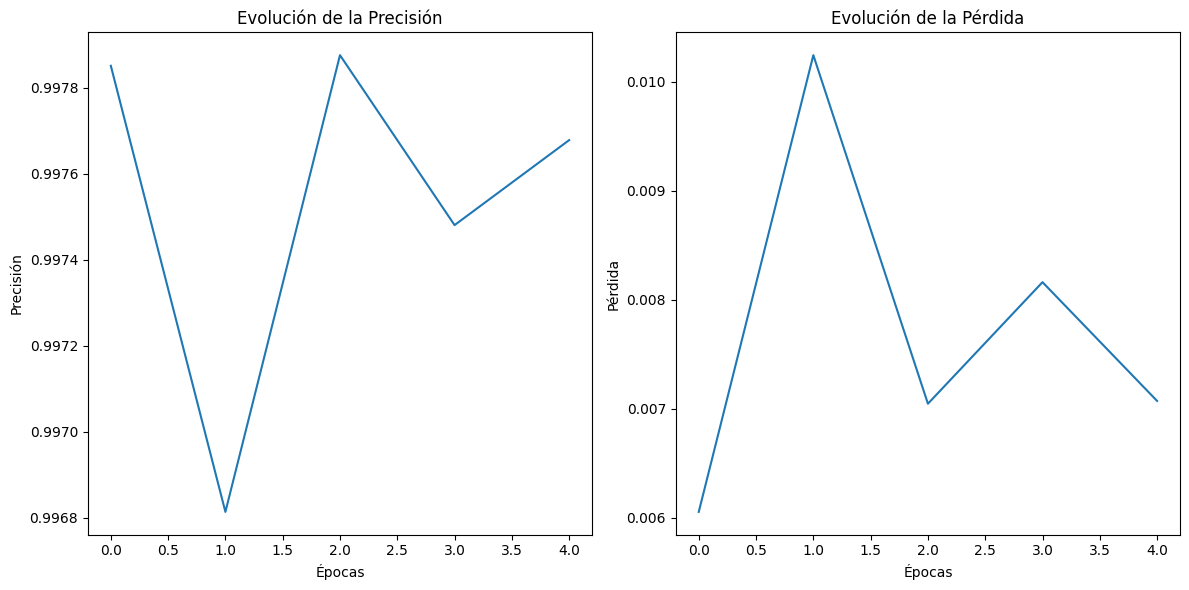

In [15]:
# Gráficos de precisión y pérdida
plt.figure(figsize=(12, 6))

# Gráfico de la precisión
plt.subplot(1, 2, 1)
plt.plot(accuracies, label='Precisión')
plt.title('Evolución de la Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')

# Gráfico de la pérdida
plt.subplot(1, 2, 2)
plt.plot(losses, label='Pérdida')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')

plt.tight_layout()
plt.show()

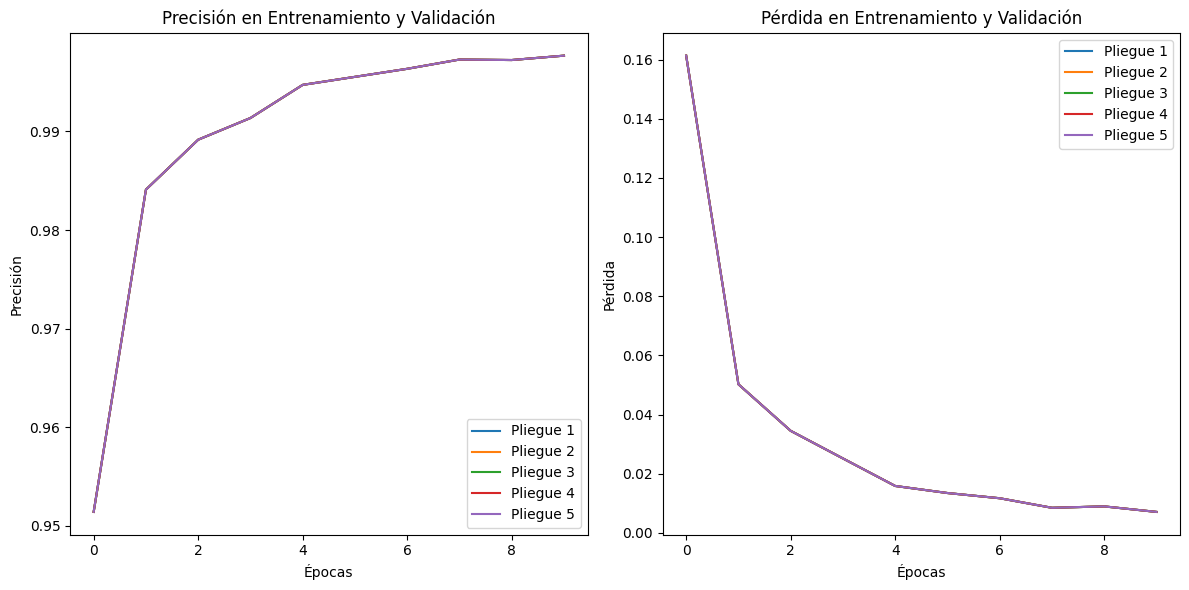

In [16]:
# Graficar curvas de precisión y pérdida durante el entrenamiento
plt.figure(figsize=(12, 6))

# Gráfico de precisión
plt.subplot(1, 2, 1)
for fold in range(len(accuracies)):
    plt.plot(history.history['accuracy'], label=f'Pliegue {fold + 1}')
plt.title('Precisión en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
for fold in range(len(losses)):
    plt.plot(history.history['loss'], label=f'Pliegue {fold + 1}')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


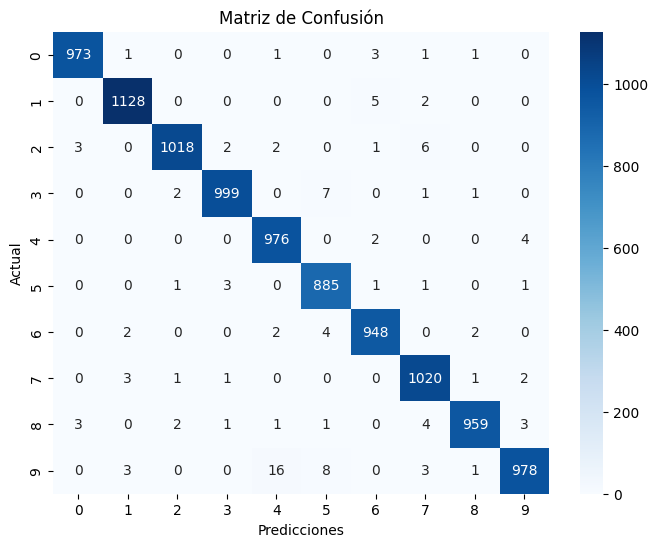

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predicción sobre el conjunto de prueba
y_pred = best_model.predict(test_images)  # Usa el mejor modelo aquí

# Convertir las predicciones a clases
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Matriz de Confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Actual')
plt.show()


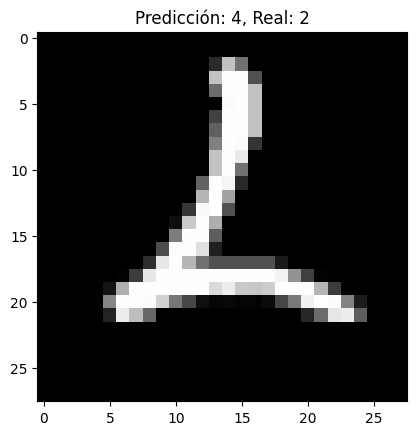

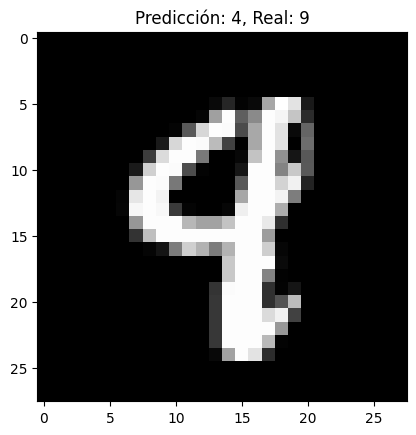

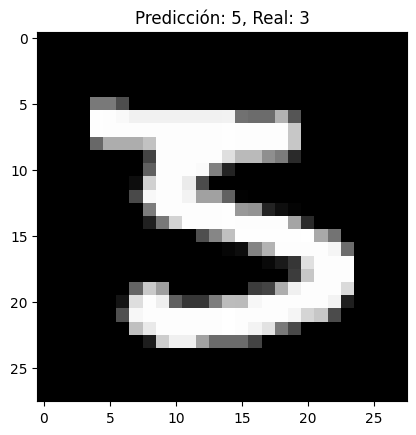

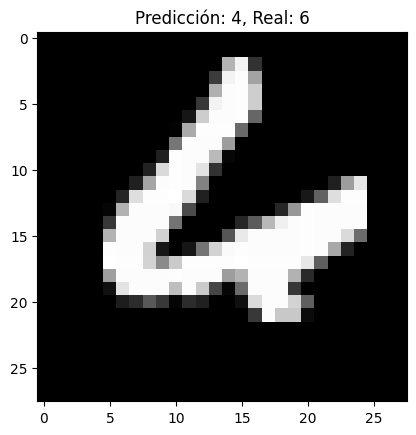

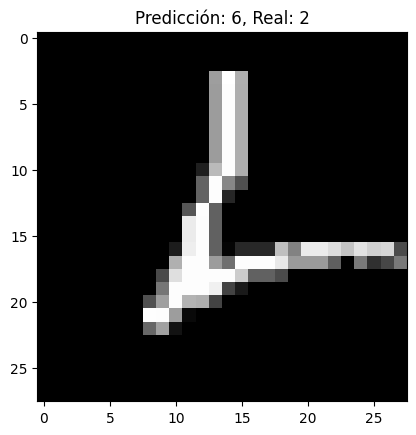

In [20]:
# Imágenes mal clasificadas
incorrect_preds = np.where(y_pred_classes != y_true_classes)[0]

# Mostrar algunas imágenes mal clasificadas
for i in range(5):  # Mostrar 5 imágenes mal clasificadas
    index = incorrect_preds[i]
    plt.imshow(test_images [index].reshape(28, 28), cmap='gray')
    plt.title(f"Predicción: {y_pred_classes[index]}, Real: {y_true_classes[index]}")
    plt.show()


## Guardado del modelo

In [18]:
# Guardar el modelo entrenado en formato .h5
model.save('modelo_kfold_reconocimiento_digitos.h5')  # Puedes cambiar por .keras

## Carga y Prueba del modelo

In [29]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

# Cargar el modelo previamente guardado
model = load_model('modelo_kfold_reconocimiento_digitos.h5')  # Asegúrate de que la ruta sea correcta

# Función para preprocesar la imagen
def preprocess_image(image_path):
    # Abrir la imagen desde el sistema de archivos
    img = Image.open(image_path)

    # Convertir a escala de grises
    img = img.convert('L')

    # Redimensionar la imagen a 28x28 píxeles (tamaño de entrada de la red)
    img = img.resize((28, 28))

    # Convertir la imagen a un array numpy y normalizarla (dividiendo por 255.0)
    img_array = np.array(img) / 255.0

    # Añadir una dimensión extra para que el array sea de forma (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)

    return img_array

# Ruta de la imagen en tu repositorio local
image_path = 'img/9-digit.png'  # Reemplaza con la ruta de la imagen en tu repositorio local

# Preprocesar la imagen
processed_image = preprocess_image(image_path)

# Realizar la predicción
prediction = model.predict(processed_image)

# Obtener la clase predicha (el dígito)
predicted_class = np.argmax(prediction)

# Mostrar el resultado
print(f'La imagen corresponde al dígito: {predicted_class}')

# Mostrar las probabilidades para cada clase (los vectores de probabilidad)
for i in range(10):
    print(f'Dígito {i}: {prediction[0][i]*100:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
La imagen corresponde al dígito: 4
Dígito 0: 3.85%
Dígito 1: 19.33%
Dígito 2: 19.18%
Dígito 3: 8.86%
Dígito 4: 25.01%
Dígito 5: 4.56%
Dígito 6: 2.02%
Dígito 7: 12.11%
Dígito 8: 1.89%
Dígito 9: 3.18%
